# Fundamental frequencies in the isochrone potential

Here we have a more complete description of the frequency analysis presented in the Introduction. We integrate several orbits in the isochrone potential, get the frequencies and set a strategy to obtain the fundamental ones, comparing with the analytical expressions. The orbit integration uses the [agama](https://github.com/GalacticDynamics-Oxford/Agama) package, but you may prefer other packages, such as [gala](http://gala.adrian.pw/en/latest/) or [galpy](https://www.galpy.org/).

The discussion and plots are based on the Appendix A of Beraldo e Silva+ 2023.

We start importing the relevant modules and setting some parameters for prettier plots:

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import agama
import naif

from matplotlib.ticker import ScalarFormatter, NullFormatter

params = {'axes.labelsize': 24, 'xtick.labelsize': 20, 
          'xtick.direction': 'in', 'xtick.major.size': 8.0,
          'xtick.bottom': 1, 'xtick.top': 1, 'ytick.labelsize': 20,
          'ytick.direction': 'in','ytick.major.size': 8.0,'ytick.left': 1,
          'ytick.right': 1,'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 32, 'font.family': 'serif'}
plt.rcParams.update(params)
columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Integrate orbits

For the initial conditions (ICs), we generate a self-consistent sample of orbits in the isochrone model (the original units in agama are such that the gravitational constant $G=1$):

In [2]:
M = 1.
Rc = 1.
n_orbs = 100

isoc_pot = agama.Potential(type='Isochrone', mass=M, scaleRadius=Rc)
isoc_df = agama.DistributionFunction(type='QuasiSpherical', potential=isoc_pot, density=isoc_pot)
isoc_data,_ = agama.GalaxyModel(isoc_pot, isoc_df).sample(n_orbs)

Note that self-consitency is not important here, but it conveniently generates a broad range of ICs. Now we integrate the orbits and calculate the apropriate coordinates:

In [3]:
n_steps = 100_000 # points per orbit
int_time = 100*isoc_pot.Tcirc(isoc_data) # integration time
orbs = agama.orbit(potential=isoc_pot, ic = isoc_data,
                   time = int_time, trajsize = n_steps+1)
t = np.vstack(orbs[:,0])[:,:-1] # time
all_coords = np.vstack(orbs[:,1]).reshape(n_orbs, n_steps+1, 6)

x = all_coords[:,:-1,0]
y = all_coords[:,:-1,1]
z = all_coords[:,:-1,2]
vx = all_coords[:,:-1,3]
vy = all_coords[:,:-1,4]
vz = all_coords[:,:-1,5]

r = np.sqrt(x**2 + y**2 + z**2)
vr = (x*vx + y*vy + z*vz)/r
phi = np.arctan2(y, x)
Lz = (x*vy - y*vx)

Note that the orbits are integrated for 100 circular times, which means each orbit has its own time array. We first define real time-series for all orbits.

## Real time-series

In [4]:
fr = r
fphi = phi

and extract the five most prominent frequencies (in a modern laptop this takes ~ 2 min. for 100 orbits):

In [5]:
n_freqs = 5

# to store the frequencies:
om_r_real = np.zeros((n_orbs, n_freqs))
om_phi_real = np.zeros((n_orbs, n_freqs))
# to store the amplitudes:
a_r_real = np.zeros((n_orbs, n_freqs), dtype=np.complex128)
a_phi_real = np.zeros((n_orbs, n_freqs), dtype=np.complex128)

for i in range(n_orbs):
    om_r_real[i], a_r_real[i] = naif.find_peak_freqs(fr[i], t[i], n_freqs=n_freqs, p=1)
    om_phi_real[i], a_phi_real[i] = naif.find_peak_freqs(fphi[i], t[i], n_freqs=n_freqs, p=1)

In case you see the output "Frequency  1  - Peak not found in first shot. Refining" for some orbit, that means that Brent's method was not able to find the maximum around the peak, and a brute force search is done in this case (that's what the parameter `n_scan_peak` is for).

Note that we explicitly set the parameter $p=1$, which is the standard value in the window function $\chi_p(t)$, but other values might improve the estimates.

Now we will take the leading frequencies to compare with the fundamental ones (remember that they are sorted in descending order of amplitude). For $\Omega_r$, we simply take the absolute value, since a negative frequency for radial oscillations is not physically meaningful. On the other hand, for $\Omega_\varphi$ we want to retain the correct sign, since there might be retrograde orbits. It would be convenient to have the correct sign extracted automatically. However, this is not the case for the real time-series (you can try it), and we impose that the sign of $\Omega_\varphi$ is the same as the one of $L_z$. Unfortunately, this is still not enough to recover the fundamental $\Omega_\varphi$ for all orbits. This is because the orbits with large apotencer distances expend most of the time far from the potencial center, effectively behaving as precessing ellipses. In some cases, the precessing frequency has a larger amplitude than the azimuthal one itself, and taking the leading frequency completely misidentify the fundamental $\Omega_\varphi$. We solve this by requiring that $|\Omega_\varphi| > |\Omega_r|/2$, which is strictly valid for the isochrone potential and generally valid for realistic galactic potentials.

In [6]:
lead_om_r_real = np.zeros(n_orbs)
lead_om_phi_real = np.zeros(n_orbs)
fund_om_phi_real = np.zeros(n_orbs)

for i in range(n_orbs):
    lead_om_r_real[i] = np.abs(om_r_real[i,0])
#     lead_om_phi_real[i] = om_phi_real[i,0]
    lead_om_phi_real[i] = np.sign(Lz[i,0])*np.abs(om_phi_real[i,0])
    
    # select the leading frequency which is > Om_r/2:
    idx_fund = np.where(np.abs(om_phi_real[i])>lead_om_r_real[i]/2.)[0]
    fund_om_phi_real[i] = np.sign(Lz[i,0])*np.abs(om_phi_real[i][idx_fund][0]) 

Now we compare with the analytical expressions for the fundamental frequencies in the isochrone model (see Binney $\&$ Tremaine 2008). For this, we need the magnitude of the angular momentum and energy, and we also calculate the apocenter distances to illustrate the difficulty raised above:

In [7]:
Lx = (y*vz - z*vy)
Ly = (z*vx - x*vz)
L = np.sqrt(Lx**2 + Ly**2 + Lz**2)

v2 = vx[:,0]**2 + vy[:,0]**2 + vz[:,0]**2
pos = np.column_stack((x[:,0].T, y[:,0].T, z[:,0].T))
E = isoc_pot.potential(pos) + 0.5*v2

rapo = np.array([np.percentile(np.sum(orb[1][:,0:3]**2, axis=1)**0.5, 100) for orb in orbs])

an_Jr = M/np.sqrt(-2*E) - 0.5*(L[:,0] + np.sqrt(L[:,0]**2 + 4*M*Rc))
an_Jtheta = L[:,0] - np.abs(Lz[:,0])
an_Jphi = Lz[:,0]

an_Om_r = M**2/(an_Jr + 0.5*(L[:,0] + np.sqrt(L[:,0]**2 + 4*M*Rc)))**3
an_Om_theta = 0.5*(1 + L[:,0]/np.sqrt(L[:,0]**2 + 4.*M*Rc))*an_Om_r
an_Om_phi = np.sign(Lz[:,0])*an_Om_theta

And let's calculate the relative erros of these estimates:

In [8]:
delta_om_r_real = np.abs((an_Om_r - lead_om_r_real)/an_Om_r)

delta_om_phi_real = np.abs((an_Om_phi - lead_om_phi_real)/an_Om_phi)
delta_fund_om_phi_real = np.abs((an_Om_phi - fund_om_phi_real)/an_Om_phi)

The plot below shows the results of these calculations:

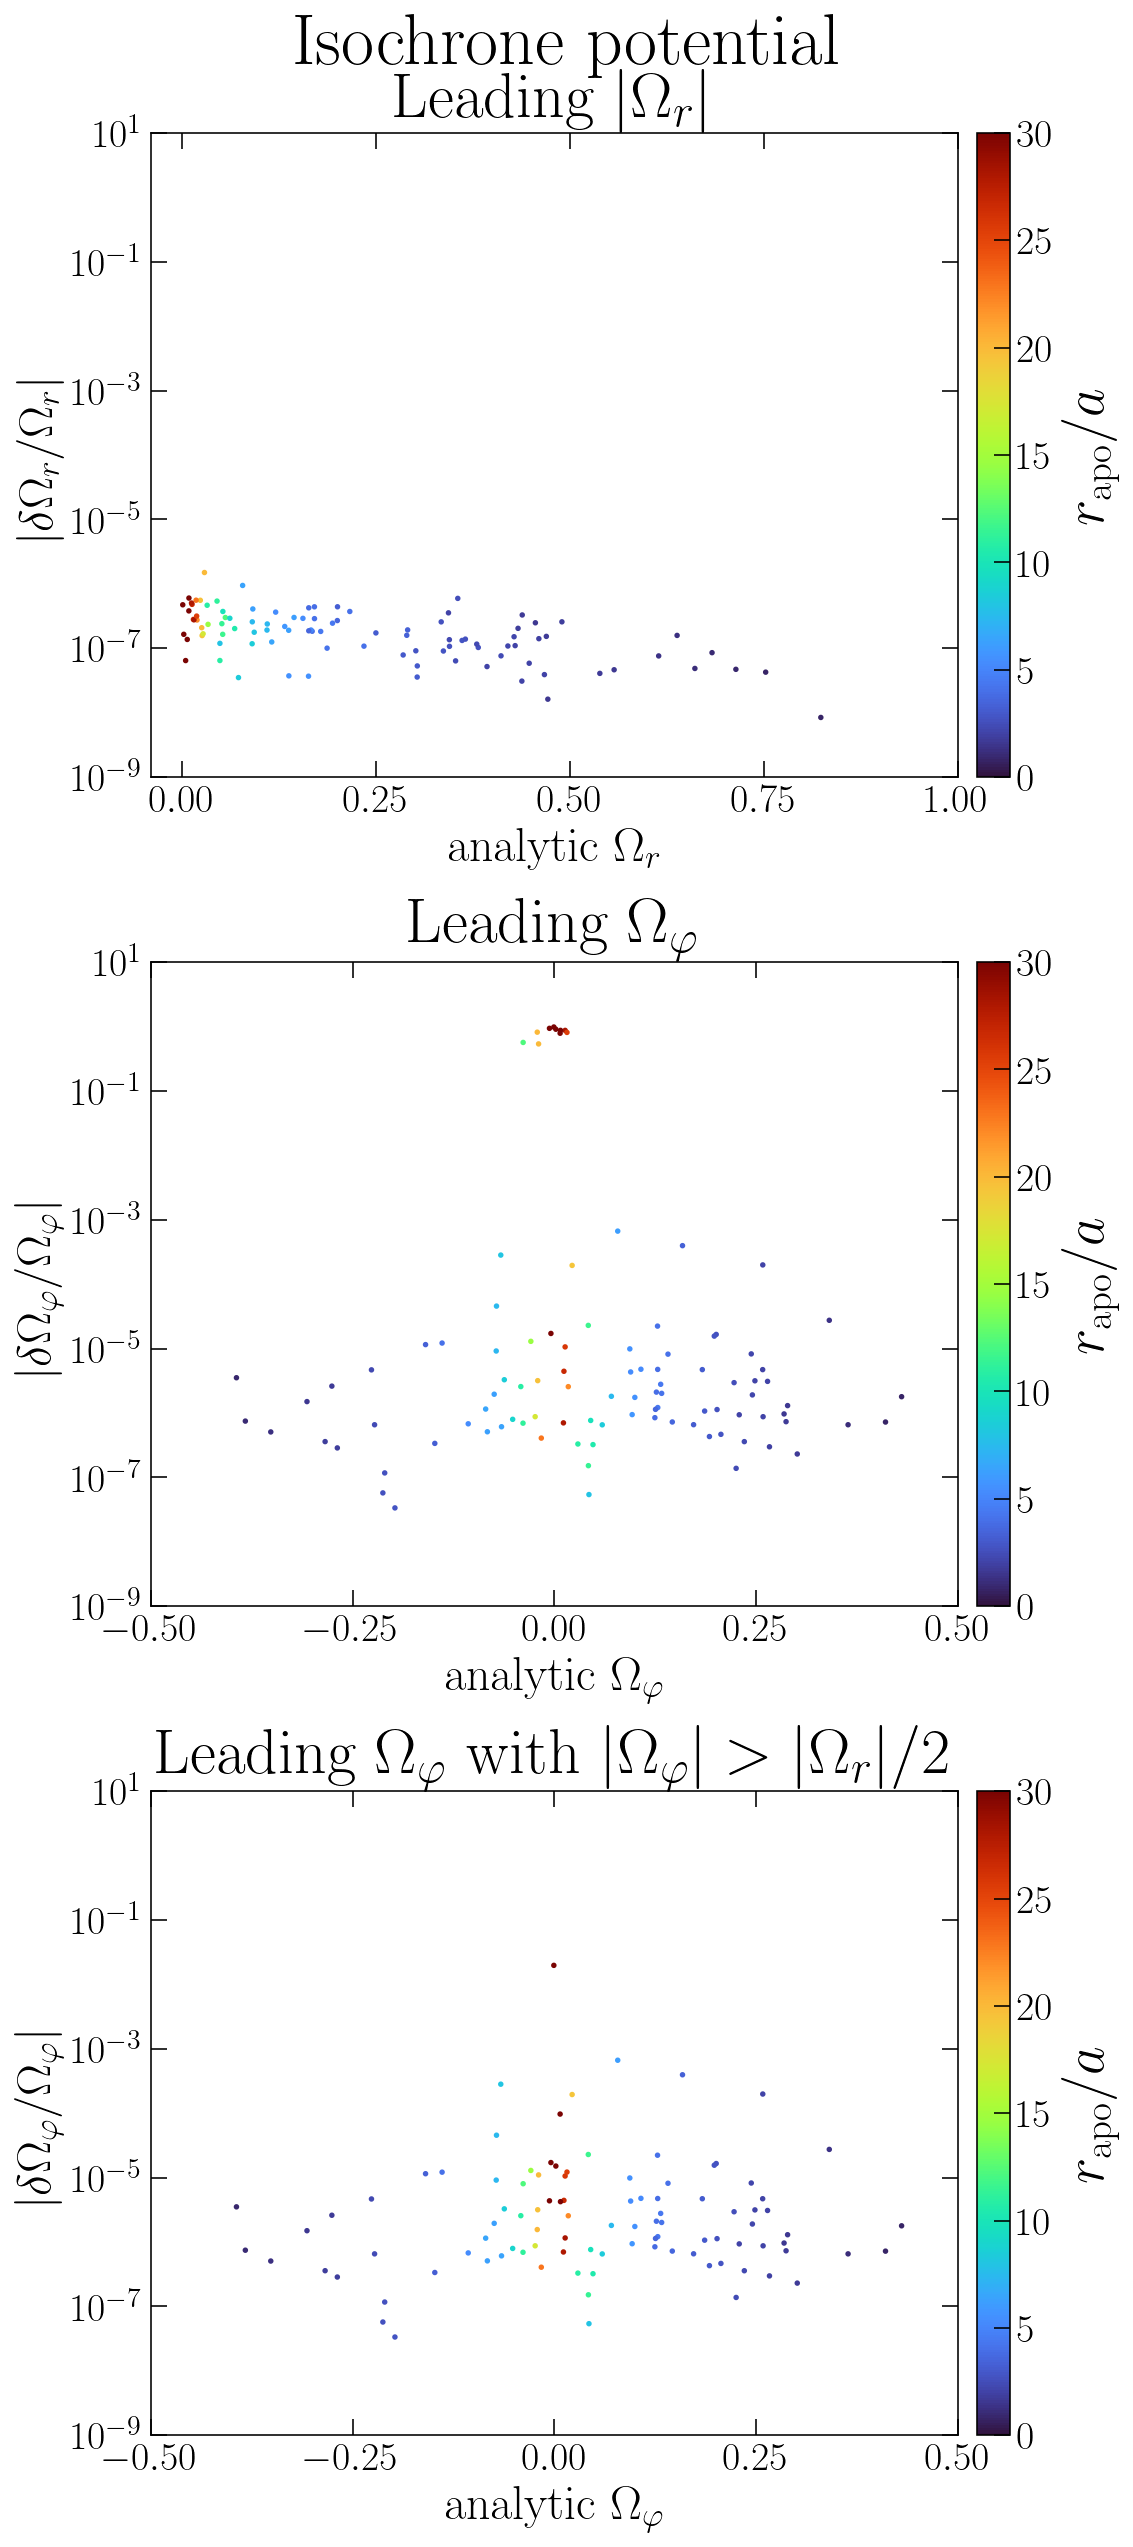

In [9]:
fig, axs = plt.subplots(3,1, figsize=(8,18))
fig.suptitle('Isochrone potential', fontsize=36)
fig.subplots_adjust(top=0.92, bottom=0.08, right=1.05, left=0.1, hspace=0.3, wspace=0.4)
fig.patch.set_facecolor('white')

cmap = plt.cm.turbo
vmin = 0
vmax = 30

cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap_rapo = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap_rapo._A = []

axs[0].set_title(r'Leading $|\Omega_r|$')
axs[0].scatter(an_Om_r, delta_om_r_real, 
               c=rapo, s=3, vmin=vmin, vmax=vmax, cmap=cmap)
#-------------------------
axs[1].set_title(r'Leading $\Omega_\varphi$')
axs[1].scatter(an_Om_phi, delta_om_phi_real, 
               c=rapo, s=3, vmin=vmin, vmax=vmax, cmap=cmap)
#-------------------------
axs[2].set_title(r'Leading $\Omega_\varphi$ with $|\Omega_\varphi| > |\Omega_r|/2$')
axs[2].scatter(an_Om_phi, delta_fund_om_phi_real,  
               c=rapo, s=3, vmin=vmin, vmax=vmax, cmap=cmap)
#-------------------------

# for i in range(2):
axs[0].set_xlabel(r'analytic $\Omega_r$')
axs[0].set_ylabel(r'$|\delta \Omega_r/\Omega_r|$')
axs[0].set_xticks(np.arange(0, 1.1, 0.25))

axs[1].set_xlabel(r'analytic $\Omega_\varphi$')
axs[1].set_ylabel(r'$|\delta \Omega_\varphi/\Omega_\varphi|$')
axs[1].set_xticks(np.arange(-0.5, 0.51, 0.25))

axs[2].set_xlabel(r'analytic $\Omega_\varphi$')
axs[2].set_ylabel(r'$|\delta \Omega_\varphi/\Omega_\varphi|$')
axs[2].set_xticks(np.arange(-0.5, 0.51, 0.25))

for i in range(3):
    axs[i].set_ylim(1e-9, 10)
    axs[i].set_yscale('log')
    axs[i].set_yticks([1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1e+1])
    
    cb = fig.colorbar(scalarMap_rapo, ax=axs[i], pad=0.02, aspect=20)
    cb.set_label(r'$r_\mathrm{apo}/a$', fontsize=28)
    cb.ax.tick_params(labelsize=20)

plt.tight_layout()

We see that for the radial component, we are good with the leading frequency (top row). But for $\Omega_\varphi$, the leading frequency is not the fundamental one for some particles with large $r_\mathrm{apo}$ (middle row). Requiring $|\Omega_\varphi| > |\Omega_r|/2$ and taking the leading frequency respecting this condition, we approximately recover the fundamental one for all orbits (bottom row).

## Complex time-series

We now repeat the frequency analysis but defining complex time-series, such that (Papaphilippou $\&$ Laskar, 1996, 1998)

$f_r = r + i v_r$

$f_\varphi = \sqrt{2|L_z|}(\cos\varphi + i\sin\varphi)$

In [10]:
fr = r + 1j*vr
fphi = np.sqrt(2.*np.abs(Lz))*(np.cos(phi) + 1j*np.sin(phi))

In [12]:
# to store the frequencies:
om_r_cmplx = np.zeros((n_orbs, n_freqs))
om_phi_cmplx = np.zeros((n_orbs, n_freqs))
# to store the amplitudes:
a_r_cmplx = np.zeros((n_orbs, n_freqs), dtype=np.complex128)
a_phi_cmplx = np.zeros((n_orbs, n_freqs), dtype=np.complex128)

for i in range(n_orbs):
    om_r_cmplx[i], a_r_cmplx[i] = naif.find_peak_freqs(fr[i], t[i], n_freqs=n_freqs, p=1)
    om_phi_cmplx[i], a_phi_cmplx[i] = naif.find_peak_freqs(fphi[i], t[i], n_freqs=n_freqs, p=1)

Now we take the leading frquencies for the complex time-series. Note that now we don't adjust the sign for $\Omega_\varphi$, but it is correctly extracted (as shown below):

In [13]:
lead_om_r_cmplx = np.zeros(n_orbs)
lead_om_phi_cmplx = np.zeros(n_orbs)
fund_om_phi_cmplx = np.zeros(n_orbs)

for i in range(n_orbs):
    lead_om_r_cmplx[i] = np.abs(om_r_cmplx[i,0])
    lead_om_phi_cmplx[i] = om_phi_cmplx[i,0]
#     lead_om_phi_cmplx[i] = np.sign(Lz[i,0])*np.abs(om_phi_cmplx[i,0])
    
    # select the leading frequency which is > Om_r/2:
    idx_fund = np.where(np.abs(om_phi_cmplx[i])>lead_om_r_cmplx[i]/2.)[0]
    fund_om_phi_cmplx[i] = om_phi_cmplx[i][idx_fund][0]

Finally, the relative errors:

In [14]:
delta_om_r_cmplx = np.abs((an_Om_r - lead_om_r_cmplx)/an_Om_r)

delta_om_phi_cmplx = np.abs((an_Om_phi - lead_om_phi_cmplx)/an_Om_phi)
delta_fund_om_phi_cmplx = np.abs((an_Om_phi - fund_om_phi_cmplx)/an_Om_phi)

And the plot below compares the estimates for both the real and complex time-series:

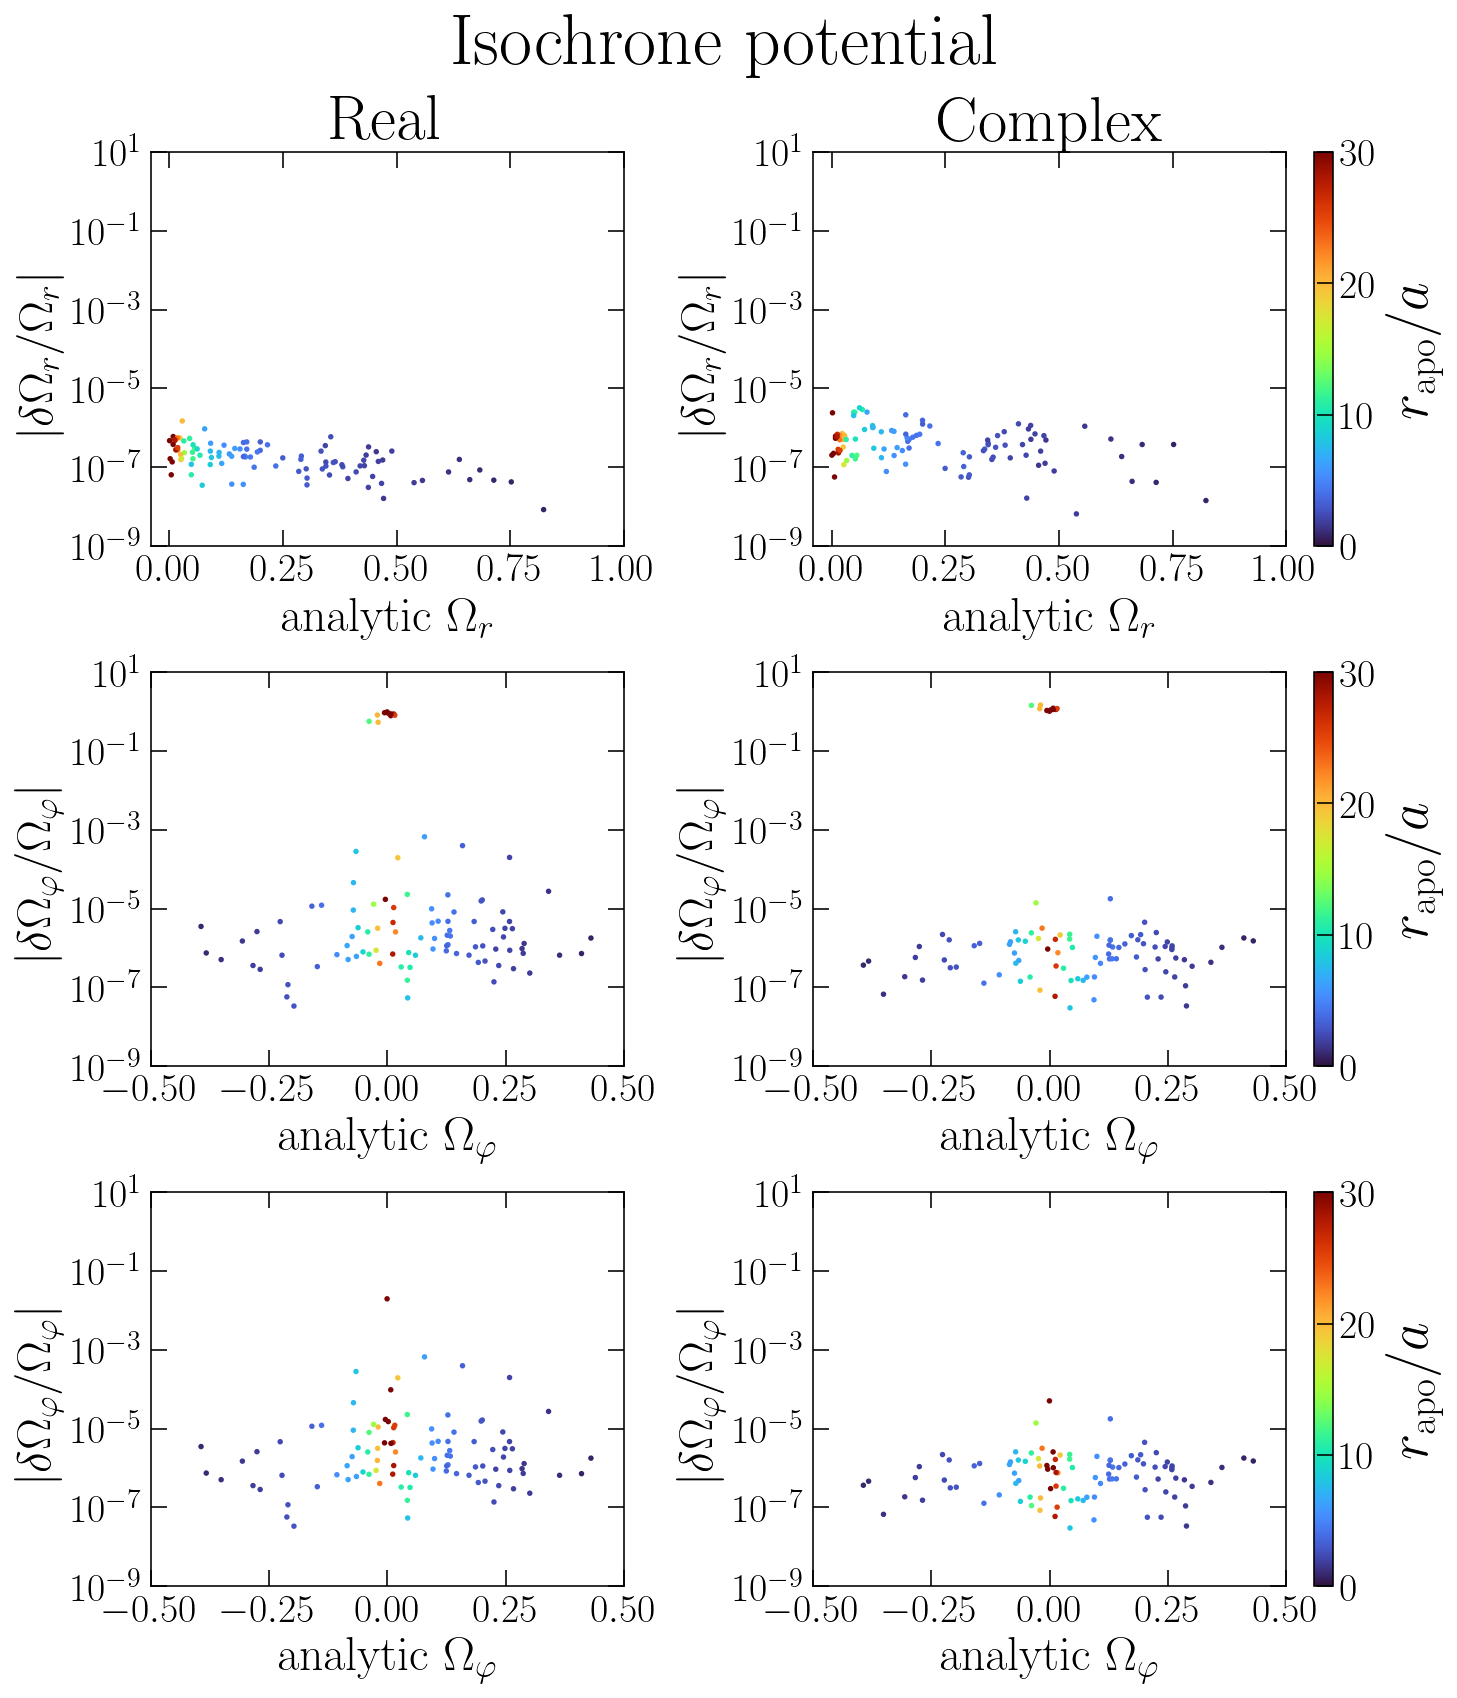

In [19]:
# Compare analytical and naif
fig, axs = plt.subplots(3,2, figsize=(10,12))
fig.suptitle('Isochrone potential', fontsize=36)

fig.subplots_adjust(top=0.9, bottom=0.07, right=1.05, left=0.1, hspace=0.32, wspace=0.4)
fig.patch.set_facecolor('white')
cmap = plt.cm.turbo

vmin = 0
vmax = 30

cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap_rapo = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap_rapo._A = []

#-------------------------
axs[0,0].set_title('Real')
axs[0,1].set_title('Complex')

axs[0,0].scatter(an_Om_r, delta_om_r_real, 
                 c=rapo, s=3, vmin=vmin, vmax=vmax, cmap=cmap)
axs[0,1].scatter(an_Om_r, delta_om_r_cmplx,
                 c=rapo, s=3, vmin=vmin, vmax=vmax, cmap=cmap)
#-------------------------
axs[1,0].scatter(an_Om_phi, delta_om_phi_real, 
                 c=rapo, s=3, vmin=vmin, vmax=vmax, cmap=cmap)
axs[1,1].scatter(an_Om_phi, delta_om_phi_cmplx, 
                 c=rapo, s=3, vmin=vmin, vmax=vmax, cmap=cmap)
#-------------------------
axs[2,0].scatter(an_Om_phi, delta_fund_om_phi_real, 
                 c=rapo, s=3, vmin=vmin, vmax=vmax, cmap=cmap)
axs[2,1].scatter(an_Om_phi, delta_fund_om_phi_cmplx, 
                 c=rapo, s=3, vmin=vmin, vmax=vmax, cmap=cmap)

for i in range(3):
    cb = fig.colorbar(scalarMap_rapo, ax=axs[i], pad=0.02, aspect=20)
    cb.set_label(r'$r_\mathrm{apo}/a$', fontsize=28)
    cb.ax.tick_params(labelsize=20)

for i in range(2):
    axs[0,i].set_xlabel(r'analytic $\Omega_r$')
    axs[0,i].set_ylabel(r'$|\delta \Omega_r/\Omega_r|$')
    axs[1,i].set_xlabel(r'analytic $\Omega_\varphi$')
    axs[1,i].set_ylabel(r'$|\delta \Omega_\varphi/\Omega_\varphi|$')
    axs[2,i].set_xlabel(r'analytic $\Omega_\varphi$')
    axs[2,i].set_ylabel(r'$|\delta \Omega_\varphi/\Omega_\varphi|$')
    axs[0,i].set_xticks(np.arange(0, 1.1, 0.25))
    axs[1,i].set_xticks(np.arange(-0.5, 0.51, 0.25))
    axs[2,i].set_xticks(np.arange(-0.5, 0.51, 0.25))
    for j in range(3):
        axs[j,i].set_ylim(1e-9, 10)
        axs[j,i].set_yscale('log')
        axs[j,i].set_yticks([1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1e+1])

We see that for $\Omega_r$ the complex time-series doesn't seem to offer advantages. For $\Omega_\varphi$, we still need to require $|\Omega_\varphi| > |\Omega_r|/2$, but the sign of $\Omega_\varphi$ is automatically extracted if we use the complex time-series, and the precision is a little bit better in this case.